In [1]:
import tensorflow as tf
from tensorflow import keras
import CO2_functions
import CO2_Processing
import pandas as pd
from CO2_functions import *
from CO2_Processing import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import os
from keras.models import model_from_json
import json

Using TensorFlow backend.


In [ ]:
import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)

from CO2_functions import *
from CO2_Processing import *

In [ ]:
#Get the data from CHPC
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-11-06','2019-11-06')

In [ ]:
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
#data = sept24_26_correction(data) #add vent vel when not monitored (instrument off)
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 

In [ ]:
#Processing for position 4
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-09-24','2019-10-03')
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
data = sept24_26_correction(data) #add vent vel when not monitored (instrument off)
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 
data['Vent_Mass'] = pd.concat([\
data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-24 08:57:00')&(data['Vent_Mass'].index<'2019-09-26 08:00:00')],\
data['Vent_Mass'].loc[(data['Vent_Mass'].index>'2019-09-26 12:00:00')&(data['Vent_Mass'].index<'2019-10-03 13:00:00')].interpolate()])

In [2]:
#Processing for position 6
data_orig = retrieve_data_from_folder('../CO2_Data_Final','2019-11-06','2019-11-27')
data = remove_spikes(pd.read_pickle('Spike_ETs.pkl'),data_orig) #remove impulses to prevent skew
data = downsample_and_concatenate(data) #sample each instrument to its respective sampling rate such that everything is equally sampled after correcting DT
data = combine_vent_data(data,1) #Combine LI_Vent and Vent_Anem_Temp into a single df by sampling rate 
data['Vent_Mass'] = moving_mass_flow(data['Vent_Mass']) #Add the moving mass flow rate based on function developed. 
for key in data:
    data[key] = pd.concat([\
                               data[key].loc[(data[key].index>'2019-11-06 00:00:00')&(data[key].index<'2019-11-25 12:00:00')],\
                               data[key].loc[(data[key].index>'2019-11-25 17:00:00')&(data[key].index<'2019-11-27 10:28:00')]])


Retrieving data for 2019-11-06
Retrieving data for 2019-11-07
Retrieving data for 2019-11-08
Retrieving data for 2019-11-09
Retrieving data for 2019-11-10
Retrieving data for 2019-11-11
Retrieving data for 2019-11-12
Retrieving data for 2019-11-13
Retrieving data for 2019-11-14
Retrieving data for 2019-11-15
Retrieving data for 2019-11-16
Retrieving data for 2019-11-17
Retrieving data for 2019-11-18
Retrieving data for 2019-11-19
Retrieving data for 2019-11-20
Retrieving data for 2019-11-21
Retrieving data for 2019-11-22
Retrieving data for 2019-11-23
Retrieving data for 2019-11-24
Retrieving data for 2019-11-25
Retrieving data for 2019-11-26
Retrieving data for 2019-11-27
Concatenating Picarro Data
Concatenating Multi Data
setting night vent data to zero


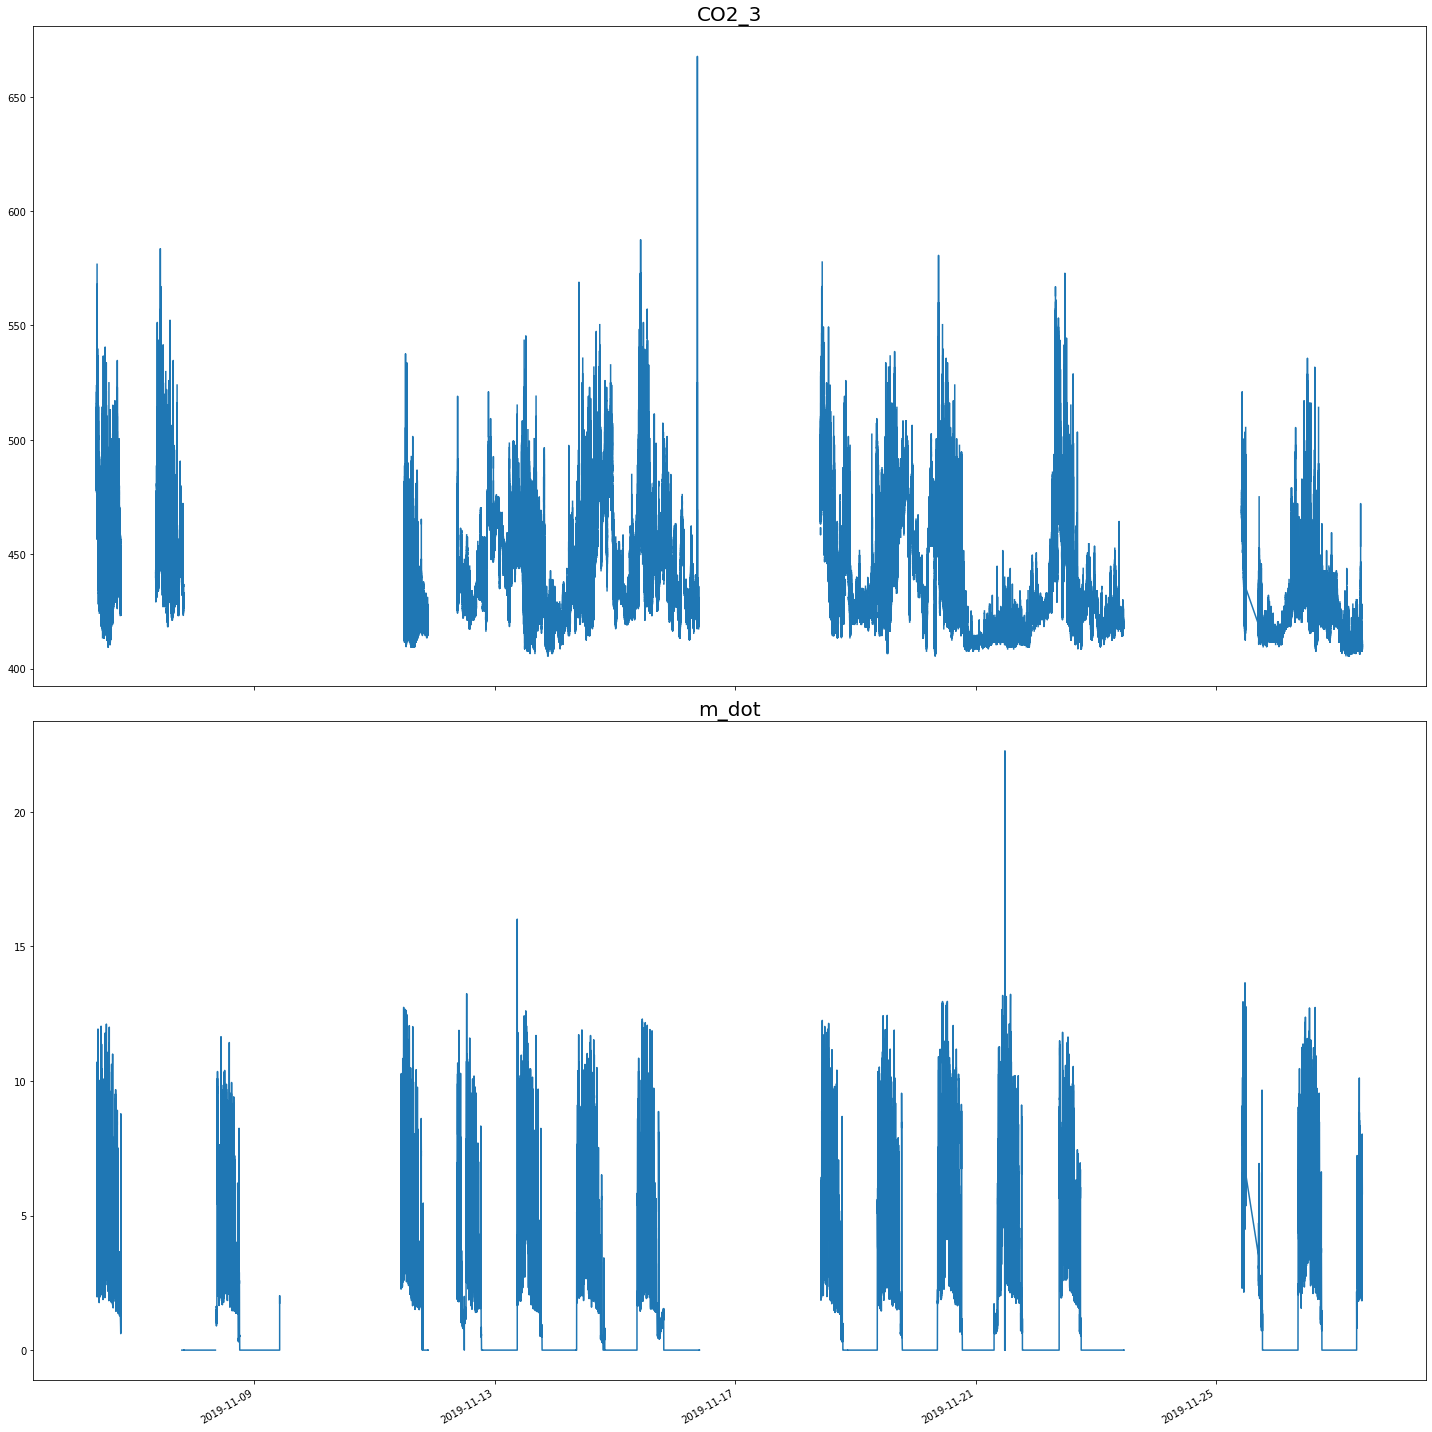

Is this an acceptable range? y


In [3]:
#Clip the picarro and vent_mass data frames to a specific region of interest

tower_id = 'Multi'
#tower_id = 'Picarro'


if tower_id == 'Multi':
    tower,vent = plot_refinement_all([[data[tower_id],'Corrected_DT','CO2_3'],\
                                    [data['Vent_Mass'],'Corrected_DT','m_dot']],\
                                   'separate')
elif tower_id == 'Picarro':
    tower,vent = plot_refinement_all([[data[tower_id],'Corrected_DT','Pic_CO2'],\
                                [data['Vent_Mass'],'Corrected_DT','m_dot']],\
                               'separate')
else:
    print('pick a valid tower')

In [4]:
#Apply a moving average and downsample
#Numbers of seconds
tower_proc = dwn_sample(tower,10)
vent_proc = dwn_sample(vent,10)

Downsampling by mean at 10 seconds
Downsampling by mean at 10 seconds


In [5]:
#Concatenate and add wind speed & direction
df = pd.concat([tower_proc,vent_proc],axis=1)
if tower_id == 'Picarro':
    df = wind_add(df,'ANEM_X','ANEM_Y')

In [6]:
#Take only necessary columns
if tower_id == 'Picarro':
    cols = ['Pic_CO2', 'ANEM_Y', 'ANEM_X', 'ANEM_Z', 'm_dot', 'wd', 'ws']
elif tower_id == 'Multi':
    cols = ['CO2_1', 'CO2_2', 'CO2_3', 'Wind_Velocity', 'Wind_Direction', 'm_dot']
    
df = df[cols]

#Make mass flux the last column
loc = df.columns.get_loc('m_dot')
cols = df.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
df = df[cols]

In [ ]:
#df = pd.read_pickle('PN_10')

In [7]:
#TIME LAG
df_to_use = df

n_seconds = 3 #how many periods to lag
n_features= len(df_to_use.columns)-1 #how many features exist in the feature matrix (number of cols - target col)
time_lagged = series_to_supervised(df_to_use,n_in=0,n_out=n_seconds,dropnan=False) #lag function
time_lagged_reframed = delete_unwanted_cols(time_lagged) #delete unneccesary columns


#Make mass flux at t the last column
loc = time_lagged_reframed.columns.get_loc('m_dot(t)')

cols = time_lagged_reframed.columns.tolist()
cols = cols[0:loc]+cols[(loc+1):]+[cols[loc]]
time_lagged_reframed = time_lagged_reframed[cols]

time_lagged_reframed

,CO2_1(t),CO2_2(t),CO2_3(t),Wind_Velocity(t),Wind_Direction(t),CO2_1(t+1),CO2_2(t+1),CO2_3(t+1),Wind_Velocity(t+1),Wind_Direction(t+1),CO2_1(t+2),CO2_2(t+2),CO2_3(t+2),Wind_Velocity(t+2),Wind_Direction(t+2),m_dot(t)
Corrected_DT,,,,,,,,,,,,,,,,
2019-11-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 00:00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 00:00:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 00:00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-06 00:00:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-27 10:27:10,421.308750,417.400000,410.191250,5.366667,175.666667,421.418889,416.312222,409.797778,5.031250,151.625000,421.553750,417.155000,410.191250,3.354444,142.000000,5.950162
2019-11-27 10:27:20,421.418889,416.312222,409.797778,5.031250,151.625000,421.553750,417.155000,410.191250,3.354444,142.000000,422.396667,417.398889,409.906667,3.463333,147.555556,5.955050
2019-11-27 10:27:30,421.553750,417.155000,410.191250,3.354444,142.000000,422.396667,417.398889,409.906667,3.463333,147.555556,421.798750,417.276250,410.922500,2.137500,161.500000,5.961353


In [ ]:
plot_refinement_all([[time_lagged,'Corrected_DT','Pic_CO2(t+1)'],[df,'Corrected_DT','Pic_CO2'],[time_lagged_reframed,'Corrected_DT','Pic_CO2(t+6)']],'stack')

In [ ]:
plot_refinement_all([[df,'Corrected_DT','Pic_CO2'],[df,'Corrected_DT','ws'],[df,'Corrected_DT','wd'],[df,'Corrected_DT','m_dot']],'separate')

In [8]:
values = time_lagged_reframed.dropna().values #Convert to numpy for processing
min_max_scalar = preprocessing.MinMaxScaler() #setup scaling
values_scaled = min_max_scalar.fit_transform(values) #scale all values from 0 to 1

#Set train size. Because time is a factor, we do not choose randomly, but chronologically
percent_train = 0.7
train_size = int(len(values)*percent_train) 

train = values_scaled[:train_size,:]  #Get train/test arrays
test = values_scaled[train_size:,:]

X_train,y_train = train[:,:-1], train[:,-1] #Get feature/target arrays
X_test, y_test = test[:,:-1], test[:,-1]

#Store shapes prior to 3D reshape such that they can be "unreshaped" and unscaled for representative fit/test plotting
orig_X_train_shape = X_train.shape
orig_X_test_shape = X_test.shape
orig_y_train_shape = y_train.shape
orig_y_test_shape = y_test.shape

X_train = X_train.reshape((X_train.shape[0], n_seconds, n_features)) 
X_test = X_test.reshape((X_test.shape[0], n_seconds, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(70210, 3, 5) (70210,) (30091, 3, 5) (30091,)


In [ ]:
#Gridsearch

from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


from keras.wrappers.scikit_learn import KerasClassifier

def create_model():
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
    def r_square(y_true, y_pred):
        from keras import backend as K
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return (1 - SS_res/(SS_tot + K.epsilon()))
    model = Sequential()
    model.add(LSTM(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

    model.compile(loss='mse',optimizer=opt,metrics=['accuracy'])
    
    return model

model = KerasClassifier(build_fn=create_model,verbose=10)

batch_size = [5,10,20,50,100]
epochs = [1,5]

param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3,verbose=10)
grid_result = grid.fit(X_train, y_train,verbose=False)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [9]:
# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

#Train Model
model = Sequential()
model.add(LSTM(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(lr=1e-3,decay=1e-5)

model.compile(loss='mse',optimizer=opt,metrics=["mean_squared_error", rmse, r_square])
history = model.fit(X_train,y_train,epochs=20,batch_size=20,validation_data=(X_test,y_test))

Train on 70210 samples, validate on 30091 samples
Epoch 1/20
70210/70210 [==============================] - 55s 780us/step - loss: 0.0181 - mean_squared_error: 0.0181 - rmse: 0.1051 - r_square: 0.0666 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_rmse: 0.1057 - val_r_square: -1920771.8750
Epoch 2/20
70210/70210 [==============================] - 53s 759us/step - loss: 0.0152 - mean_squared_error: 0.0152 - rmse: 0.0942 - r_square: 0.2196 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_rmse: 0.0941 - val_r_square: -1314885.8750
Epoch 3/20
70210/70210 [==============================] - 54s 776us/step - loss: 0.0147 - mean_squared_error: 0.0147 - rmse: 0.0918 - r_square: 0.2543 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_rmse: 0.0815 - val_r_square: -789532.2500
Epoch 4/20
70210/70210 [==============================] - 54s 770us/step - loss: 0.0143 - mean_squared_error: 0.0143 - rmse: 0.0896 - r_square: 0.2758 - val_loss: 0.0144 - val_mean_squared_error:

In [ ]:
#Write out model
name = 'test'

hist_df = pd.DataFrame(history.history)
model_json = model.to_json()
with open("ML_Models/{}_model.json".format(name), "w") as json_file:
    json_file.write(model_json)
model.save_weights("ML_Models/{}_model.h5".format(name))
with open('ML_Models/{}_hist.json'.format(name), 'w') as f:
    hist_df.to_json(f)
print("Saved model to disk")

# DEVELOPMENT 
________________________
# VIEWING

In [ ]:
#Read in model
path = 'ML_Models/Dense_sigmoid_PN6BS20E10'

json_file = open('{}_model.json'.format(path), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("{}_model.h5".format(path))
history = pd.read_json("{}_hist.json".format(path))
print("Loaded model from disk")

In [ ]:
#Get train/test
X_train,X_test,y_train,y_test,min_max_scalar = process_for_ML_test(['Pic_CO2','ANEM_X','ANEM_Y','ANEM_Z','wd','ws'],15,6)

In [12]:
y_fit = model.predict(X_test) #fit to x_test

In [ ]:
model.summary()

In [ ]:
hist_df = pd.DataFrame(history.history)
plt.plot(hist_df['loss'])
#plt.plot(history['val_accuracy'])
#plt.plot(history['loss'])
#plt.plot(history['val_loss'])

In [13]:
#Return to original data shape and scale
X_test_original_shape = X_test.reshape(orig_X_test_shape) #reshape from 3d time
y_test_original_shape = y_test.reshape(orig_y_test_shape) #reshape from 3d time 

merged_tests = np.concatenate((X_test_original_shape,y_test_original_shape[:,None]),axis=1) #concat X and y
unscaled_test = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1] #unscale using declared scalar

y_fit_original_shape = y_fit.reshape(orig_y_test_shape)
merged_tests = np.concatenate((X_test_original_shape,y_fit_original_shape[:,None]),axis=1)
unscaled_fit = pd.DataFrame(min_max_scalar.inverse_transform(merged_tests)).iloc[:,-1]

#Put into pandas df
comparison = pd.concat([unscaled_test,unscaled_fit],axis=1)
comparison.columns = ['test','fit']

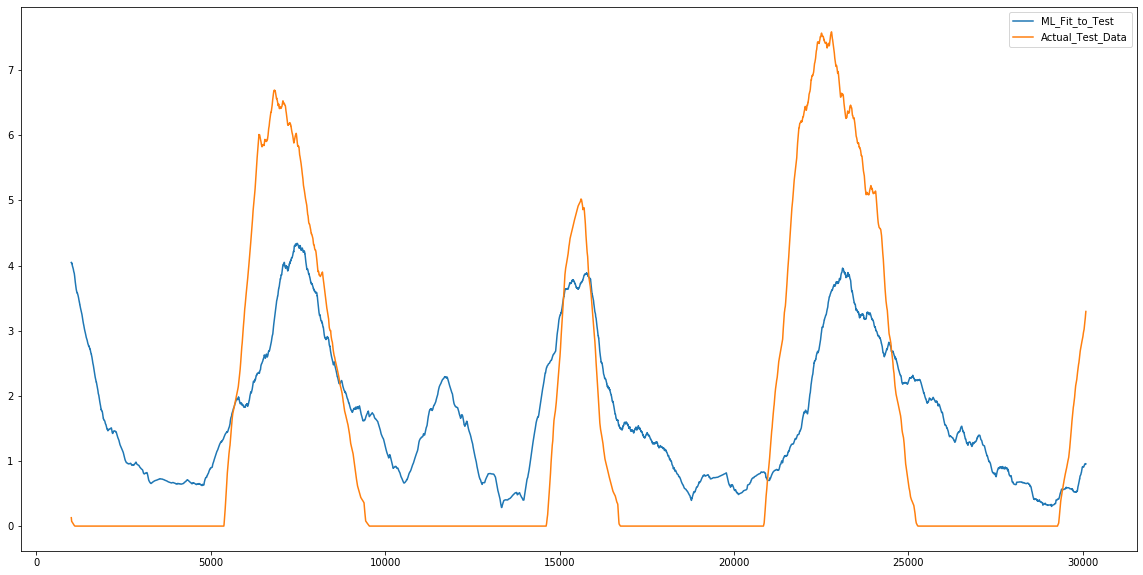

In [17]:
#PLOT PREDICTED VS OBSERVED
fig, ax = plt.subplots(figsize = (20,10))
# ax.plot(yfit,label='ML_Fit_to_Test')
# ax.plot(y_test,label='Actual_Test_Data')

roll = 1000

ax.plot(comparison['fit'].rolling(roll).mean(),label='ML_Fit_to_Test')
ax.plot(comparison['test'].rolling(roll).mean(),label='Actual_Test_Data')
ax.legend()